In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path="/content/drive/MyDrive/COMP9444/neural-style-transfer-pytorch"
os.chdir(path)
os.listdir(path)

['vgg16-00b39a1b.pth',
 'vgg19-d01eb7cb.pth',
 'models',
 'images',
 'out500.png',
 'out0.png',
 'out100.png',
 'out200.png',
 'out300.png',
 'out400.png',
 'out499.png',
 'images.zip',
 'neural_style_preserve_color.ipynb']

# COMP9444 Neural Color Style Transfer

For a painting, at the physical level, we believe that there are three parts that can be created: "painting content", "painting tools" and "color matching". For the current style transfer, the texture part is transferred as the style. In other words, the current AI can select its own drawing tools to draw specific objects to a certain extent. Our work is mainly based on the style transfer of the IOB-NST method, adding an interesting color transfer part. 
For our project, this may an exploratory fresh start, rather than an improvement. Our preliminary expectation for this project is that the style, content and color can be customized to obtain paintings, such as a colorful starry abstraction or a dreamy ink painting style castle. We implemented it in two different ways, using different styles and content layers, and different networks for comparison. 

This implementation is inspired by the implementations of:
* [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) by Leon Gatys, Alexander Ecker, and Matthias Bethge. 
* https://github.com/rrmina/neural-style-pytorch,
* Justin Johnson [Neural Style in Torch](https://github.com/jcjohnson/neural-style), and
* ProGamerGov [Neural Style in PyTorch](https://github.com/ProGamerGov/neural-style-pt)

The [original caffe pretrained weights of VGG19](https://github.com/jcjohnson/pytorch-vgg) were used for this implementation, instead of the pretrained VGG19's in PyTorch's model zoo.

> Note: we ran through our program on Colab and using the path of our Google drive. If you go through the code by another device please download all required files from [here](https://drive.google.com/drive/folders/1GgCOlVWZkqccze4niojXA1Xp-EjOPTdw?usp=sharing)

Our program has three inputs, a style picture, a color picture and a content picture, and the final output picture has the style of the style picture, the color of the color picture, and the content of the content picture at the same time. 
We hope that this will enable AI to have a better anthropomorphic artistic creation ability.

In [ ]:
# Import all required module
import torch
import torch.nn as nn
import torch.optim as optim

import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

import cv2
import copy
from PIL import Image

In [ ]:
# Print the device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# We refer to https://github.com/rrmina/neural-style-pytorch's program for inspiration
# Load image file
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

# Show image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()
    
# Save Image as out{num_iterms}.png
def saveimg(img, iters):
    if (PIXEL_CLIP=='True'):
        img = img.clip(0, 255)
    cv2.imwrite('out'+str(iters)+'.png', img)
    
# Color transfer
def transfer_color(src, dest):
    if (PIXEL_CLIP=='True'):
        src, dest = src.clip(0,255), dest.clip(0,255)
        
    # Resize src to dest's size
    H,W,_ = src.shape 
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
    
    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr
    
    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)  #4 Convert new image from YIQ back to BGR

# Processing the image
* itot - transform image to tensor
* ttoi - transform tensor to image

This implementation is inspired by [Rusty from github](https://github.com/rrmina/neural-style-pytorch)

In [ ]:
# Preprocessing
def itot(img):
    # Rescale the image
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H,W]))*x) for x in [H, W]])
    
    itot_t = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # Subtract the means
    normalize_t = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalize_t(itot_t(img)*255)
    
    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

def ttoi(tensor):
    # Add the means
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])
    
    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    img = ttoi_t(tensor)
    img = img.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

# Data source
In our project, we don't have the large dataseet to process. We only need a few images as content image, style image and color image.

For the images we used, you can download the images.zip ithrough [google drive link](https://drive.google.com/drive/folders/1GgCOlVWZkqccze4niojXA1Xp-EjOPTdw?usp=sharing) and unzip the images.zip.



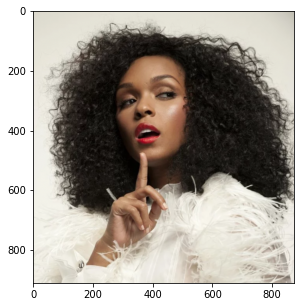

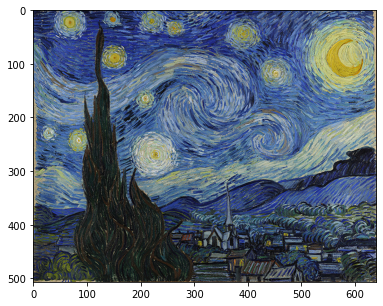

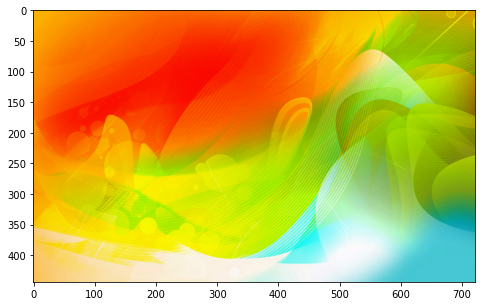

In [ ]:
# Image Files
INIT_IMAGE = 'random' # or 'content'
PIXEL_CLIP = 'True' # or 'False' - Clipping produces better images
CONTENT_PATH = 'images/1-content.png' # It can be changed to the path of you chosed images.
STYLE_PATH = 'images/1-style.jpg'
COLOR_PATH = 'images/1-color.png'

# Load Images
content_img = load_image(CONTENT_PATH)
style_img = load_image(STYLE_PATH)   
color_img = load_image(COLOR_PATH) 

# Show Images
show(content_img)
show(style_img)
show(color_img)

# Model selection
PRETRAINED VGG MODELS

GITHUB REPO: https://github.com/jcjohnson/pytorch-vgg
* VGG19 - https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
* VGG16 - https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

If use GOOGLE COLAB, add this block to notebook to download the model files. 
```
# Download VGG19 Model
!wget -c https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
!mkdir models
!cp vgg19-d01eb7cb.pth models/
# Download VGG16 Model
!wget -c https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
!cp vgg16-00b39a1b.pth models/
```

In [ ]:
VGG19_PATH = 'models/vgg19-d01eb7cb.pth'
VGG16_PATH = 'models/vgg16-00b39a1b.pth'

In [ ]:
# Load VGG19 Skeleton
vgg19 = models.vgg19(pretrained=False)
# Load VGG16 Skeleton
vgg16 = models.vgg16(pretrained=False)

# Load pretrained weights
vgg19.load_state_dict(torch.load(VGG19_PATH), strict=False)
# Load pretrained weights
vgg16.load_state_dict(torch.load(VGG16_PATH), strict=False)

# Change Pooling Layer
def pool_(model, pool='avg'):
    if (pool=='avg'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            ct+=1
    elif (pool=='max'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.AvgPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            ct+=1
            
    return model

# in our project we did not change the pooling layer, use average pooling layer as default
# POOL = 'max'
# vgg.features = pool_(vgg.features, POOL)

# Extract only the 'features' network, 'classifier' network is not needed in our project
model = copy.deepcopy(vgg19.features) # vgg19
model.to(device)
# model = copy.deepcopy(vgg16.features) # if use vgg16 uncomment these two lines and comment the above two lines
# model.to(device)

# Turn-off unnecessary gradient tracking
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
"""
Loss Functions
All loss functions are basically Mean of the Squared Errors (MSE)
g - generated features
c - content features
s - style features

1. What is Total Variation(TV) Loss ???
    The total variation (TV) loss encourages spatial smoothness in the generated image. 
   It was not used by Gatys et al in their CVPR paper but it can sometimes improve the 
   results; for more details and explanation see Mahendran and Vedaldi 
   "Understanding Deep Image Representations by Inverting Them" CVPR 2015.

   - @jcjohnson
   https://github.com/jcjohnson/neural-style/issues/302

2. How to implement TV Loss?
    https://en.wikipedia.org/wiki/Total_variation_denoising
"""
mse_loss = torch.nn.MSELoss()
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

def content_loss(g, c):
    loss = mse_loss(g, c)
    return loss
    
def style_loss(g, s):
    # print(g.shape)
    c1,c2 = g.shape
    loss = mse_loss(g, s)
    return loss / (c1**2) # Divide by square of channels

def tv_loss(c):
    x = c[:,:,1:,:] - c[:,:,:-1,:]
    y = c[:,:,:,1:] - c[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

In [ ]:
# VGG Forward Pass
def get_features(model, tensor):
    # vgg19
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '17' : 'relu3_4',
        '26' : 'relu4_4',
        '35' : 'relu5_4',
        '6' : 'relu2_1', # Content layers choose relu2_1 or relu3_1 or relu4_1 or relu5_1
        '11' : 'relu3_1',
        '20' : 'relu4_1',
        '29' : 'relu5_1'
    }
    '''
    # vgg16
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '15' : 'relu3_3',
        '22' : 'relu4_3',
        '29' : 'relu5_3',
        '6' : 'relu2_1', # Content layers choose relu2_1 or relu3_1 or relu4_1 or relu5_1
        '11' : 'relu3_1',
        '18' : 'relu4_1',
        '25' : 'relu5_1'
    }
    '''
    # Get features
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        # print(name)
        if name in layers:
            if (name=='6'):   # relu2_1 vgg19 6, vgg16 6
                features[layers[name]] = x
            elif (name=='11'): # relu3_1 vgg19 11, vgg16 11
                features[layers[name]] = x
            elif (name=='20'): # relu4_1 vgg19 20, vgg16 18
                features[layers[name]] = x
            elif (name=='29'): # relu5_1 vgg19 29, vgg16 25
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h*w)
            # print(name)    
            # Terminate forward pass
            if (name == '35'): # vgg19 35, vgg16 29
                break
            
    return features

In [ ]:
# Generate Initial Image
def initial(c_tensor, init_image='random'):
    B, C, H, W = c_tensor.shape
    if (init_image=='random'):
        #tensor = torch.randn(C, H, W).mul(torch.std(content_tensor.clone().cpu())/255).unsqueeze(0)
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = c_tensor.clone().detach()
    
    return tensor

In [ ]:
"""
Define Optimizer
The optimizer minimizes the total loss by updating the tensor 'x'.
"""
def chose_optim(OPTIMIZER, x):
    if (OPTIMIZER=='lbfgs'):
        optimizer = optim.LBFGS([x])
    elif (OPTIMIZER=='adam'):
        optimizer = optim.Adam([x], lr=ADAM_LR)
    return optimizer

Different convolutional layers as the content layer there are different results in feature extraction.

In [ ]:
from matplotlib.artist import kwdoc
def stylize(c_tensor,s_tensor,k, PRESERVE_COLOR, c_layer, iteration):     
    # Get features representations/Forward pass
    content_layers = [c_layer] # relu2_1, relu3_1, relu4_1, relu5_1
    content_weights = {c_layer: 1.0} # relu2_1, relu3_1, relu4_1, relu5_1
    # use vgg19
    style_layers = ['relu1_2', 'relu2_2', 'relu3_4', 'relu4_4', 'relu5_4']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_4': 0.2, 'relu4_4': 0.2, 'relu5_4': 0.2}
    '''
    # use vgg16, there is one less layer than vgg19 in conv4 and conv5
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
    '''
    c_feat = get_features(model, c_tensor)
    s_feat = get_features(model, s_tensor)
    optimizer = chose_optim(OPTIMIZER,k)
    
    i = [0]
    while i[0] < iteration:
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            g_feat = get_features(model, k)

            # Compute Losses
            c_loss=0
            s_loss=0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                # print(j)
                s_loss += style_weights[j] * style_loss(g_feat[j], s_feat[j])
            
            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(k.clone().detach())
            total_loss = c_loss + s_loss + t_loss

            # Backprop
            total_loss.backward(retain_graph=True)
            
            # Print Loss, show and save image
            i[0]+=1
            if (((i[0] % SHOW_ITER) == 1) or (i[0]==NUM_ITER)):
                print("Style Loss: {} Content Loss: {} TV Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), t_loss, total_loss.item()))
                if (PRESERVE_COLOR=='True'):
                    g_ = transfer_color(ttoi(c_tensor.clone().detach()), ttoi(k.clone().detach()))
                else:
                    g_ = ttoi(k.clone().detach())
                show(g_)
                saveimg(g_, i[0]-1)
                plt.show()
            
            return (total_loss)
        
        # Weight/Pixel update
        optimizer.step(closure)
    return k

In [ ]:
# Hyperparameters
MAX_IMAGE_SIZE = 512

# Optimizer
OPTIMIZER = 'lbfgs' #or 'adam'
ADAM_LR = 10
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3
NUM_ITER = 500
SHOW_ITER = 100

In [ ]:
# Convert Images to Tensor
content_tensor = itot(content_img).to(device)
color_tensor = itot(color_img).to(device)
style_tensor = itot(style_img).to(device)
g = initial(content_tensor, init_image=INIT_IMAGE)
g1 = g.to(device).requires_grad_(True)
g2 = g.to(device).requires_grad_(True)
color = initial(color_tensor, init_image=INIT_IMAGE)
color = color.to(device).requires_grad_(True)

Method 1: Two times transfer style
* Step 1: color as content + texture as style (preserve content color)

* Step 2: content as content + step 1 result as style (not preserve color)

![Method 1](https://github.com/yuxin714/9444-Neural-Style-Transfer/blob/main/method1.png?raw=true)

Here, we use relu4-1 as the content layer. If want to try another layer can change it when calling the stylize function.

Style Loss: 63067464.0 Content Loss: 2788159.5 TV Loss: 1.0858476161956787 Total Loss : 65855624.0


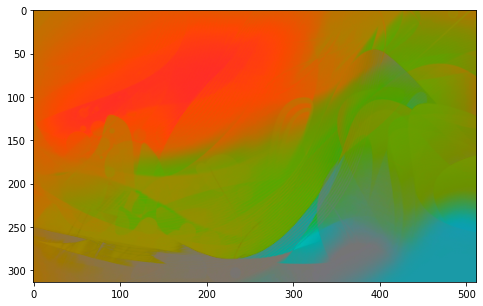

Style Loss: 327388.21875 Content Loss: 2034434.0 TV Loss: 13117.4990234375 Total Loss : 2374939.75


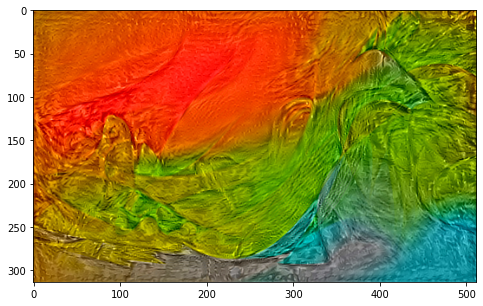

Style Loss: 197649.796875 Content Loss: 1727263.875 TV Loss: 14472.232421875 Total Loss : 1939385.875


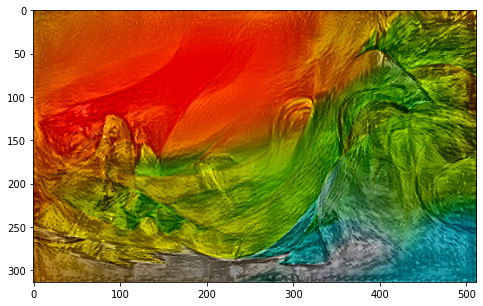

Style Loss: 173898.390625 Content Loss: 1648034.875 TV Loss: 15721.958984375 Total Loss : 1837655.25


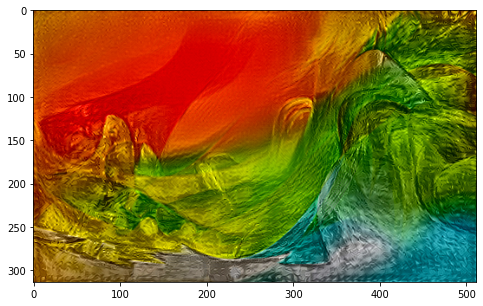

Style Loss: 166410.78125 Content Loss: 1614478.75 TV Loss: 17228.494140625 Total Loss : 1798118.0


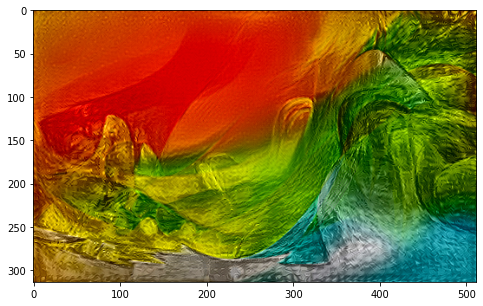

Style Loss: 165039.53125 Content Loss: 1599001.5 TV Loss: 18210.56640625 Total Loss : 1782251.625


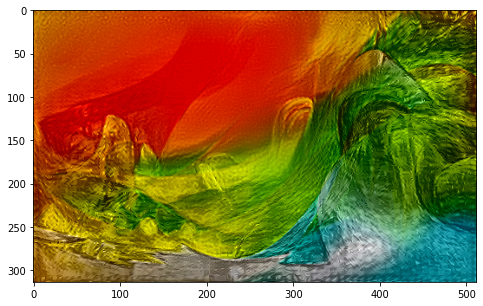

In [ ]:
# Method 1, step 1: color as content + texture as style (preserve content color)
content_layer = 'relu4_1' # can change to 'relu2_1' or 'relu3_1' or 'relu5_1'
out_style = stylize(color_tensor,style_tensor, color,'True',content_layer,NUM_ITER)

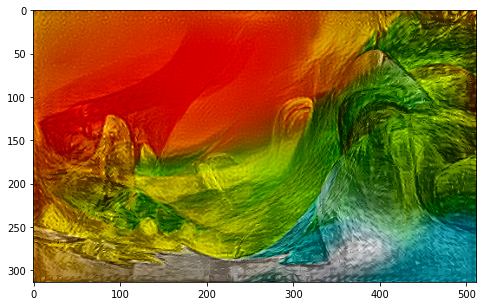

In [ ]:
c_clone = ttoi(color_tensor.clone().detach())
color_clone = ttoi(color.clone().detach())
new_style_m1 = transfer_color(c_clone, color_clone) # Style Transfer to color (Preserve color of color diagram)
show(new_style_m1) # the orignal new style image

Process the pixel matrix to the one that can be used in stylized function
* step 1: Find the maximum and minimum of the pixel matrix
* step 2: Normalize to [0,255]
* step 3: Contrast stretching

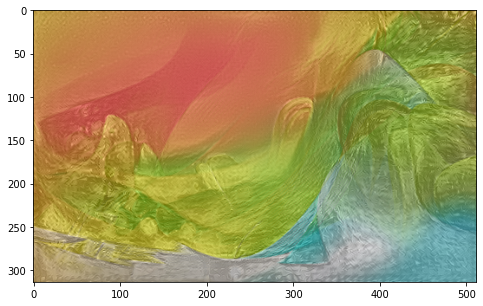

In [ ]:
def normalize(new_style):
    Min=999999
    Max=-999999
    for i in range(0,len(new_style)):         # find the maximum and minimum of the pixel matrix
        now_min=np.min(new_style[i])
        now_max=np.max(new_style[i])
        if now_min<Min:
            Min=now_min
        if now_max>Max:
            Max=now_max
    for j in range(0,len(new_style)):         # normalize to [0,255]
        new_style[j] = (new_style[j]-Min)*255/(Max-Min)
    return new_style

new_style_m1 = normalize(new_style_m1)
show(new_style_m1) # image after normalization

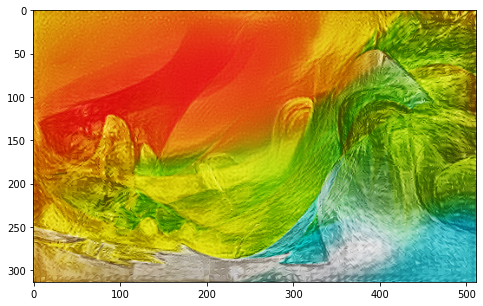

In [ ]:
# Contrast stretching
def contrast_stretching(new_style):
    img_temp = 1 / (1 + np.power((140/(new_style+1e-6)), 4.5))       # 4.5 for slope, interactive selection
    temp2 = img_temp - np.min(img_temp)                             # normalize to [0,255] before BGR2RGB
    img_con_str = np.uint8(255*(temp2/np.max(temp2)))
    return img_con_str

img_con_str_m1 = contrast_stretching(new_style_m1)
show(img_con_str_m1) # image after contrast stretching

Style Loss: 83120816.0 Content Loss: 1929750.0 TV Loss: 1.698176622390747 Total Loss : 85050568.0


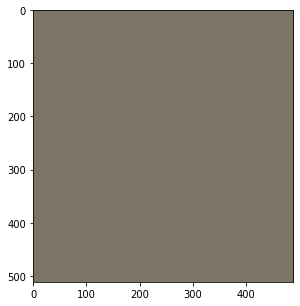

Style Loss: 1926532.75 Content Loss: 2154531.5 TV Loss: 20845.345703125 Total Loss : 4101909.5


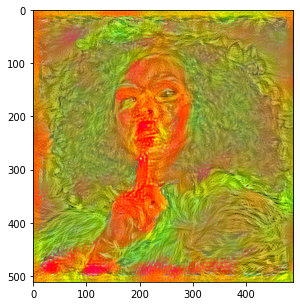

Style Loss: 272144.21875 Content Loss: 1406606.375 TV Loss: 20645.580078125 Total Loss : 1699396.25


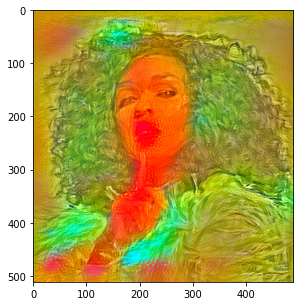

Style Loss: 182944.84375 Content Loss: 1273042.5 TV Loss: 21491.044921875 Total Loss : 1477478.375


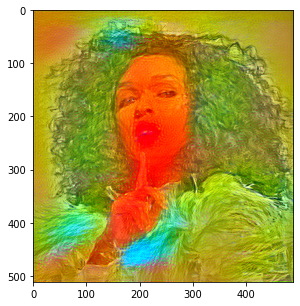

Style Loss: 168549.78125 Content Loss: 1229971.0 TV Loss: 23341.037109375 Total Loss : 1421861.75


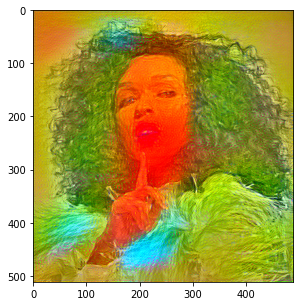

Style Loss: 165483.828125 Content Loss: 1212047.5 TV Loss: 24711.18359375 Total Loss : 1402242.5


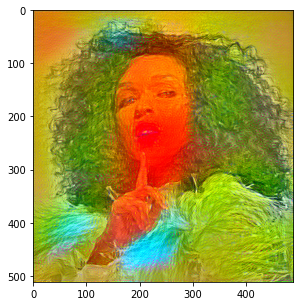

Style Loss: 164727.8125 Content Loss: 1212677.625 TV Loss: 24761.2734375 Total Loss : 1402166.75


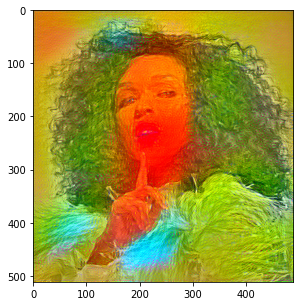

In [ ]:
# Method 1, step 2: content as content + step 1 result as style (not preserve color)
new_style_tensor_m1 = itot(img_con_str_m1).to(device)
# PRESERVE_COLOR = 'False'
# content_layer = 'relu4_1' # use same content layer as step 1 as default, can change to aonther layer
out_content_m1 = stylize(content_tensor,new_style_tensor_m1, g1,'False',content_layer,iteration=NUM_ITER)

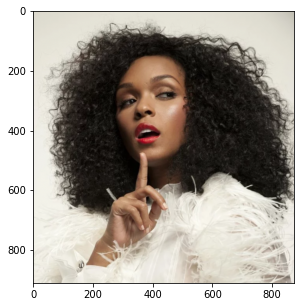

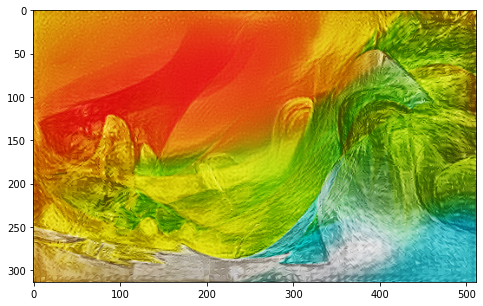

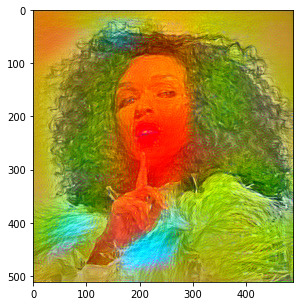

In [ ]:
show(content_img) # Original Content
show(img_con_str_m1) # merge color and style after image processing
show(ttoi(out_content_m1.clone().detach())) # Final Transfer
# saveimg(ttoi(out_content.clone().detach()), NUM_ITER)

Method 2: one time transfer
* step 1: overlay the color directly onto the style image

* step 2: The output of the previous step is used as the style, and the face is used as the content

![Method 2](https://github.com/yuxin714/9444-Neural-Style-Transfer/blob/main/method2.png?raw=true)


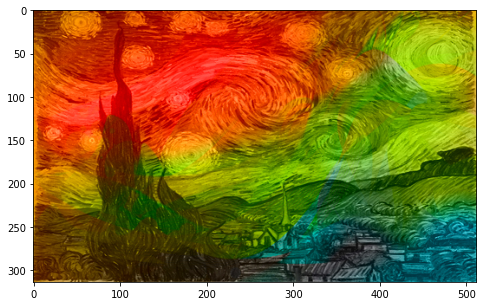

In [ ]:
# method 2, step 1: overlay the color directly onto the style image
color_clone = ttoi(color_tensor.clone().detach())
style_clone = ttoi(style_tensor.clone().detach())
new_style_m2 = transfer_color(color_clone,style_clone)
show(new_style_m2)

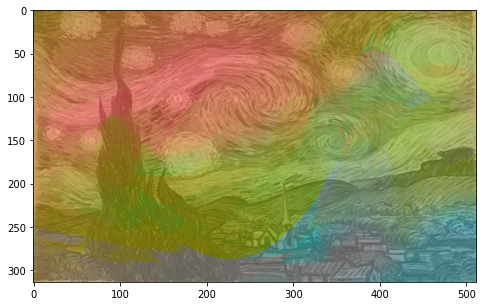

In [ ]:
# Calling image processing functions
new_style_m2 = normalize(new_style_m2)
show(new_style_m2) # image after normalization

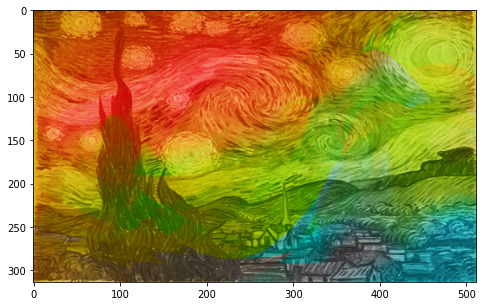

In [ ]:
img_con_str_m2 = contrast_stretching(new_style_m2)
show(img_con_str_m2) # image after contrast stretching

Style Loss: 76812672.0 Content Loss: 1929750.0 TV Loss: 1.698176622390747 Total Loss : 78742424.0


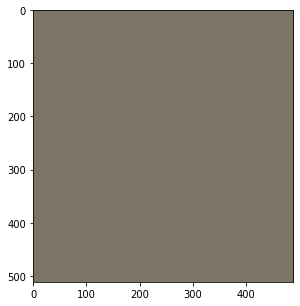

Style Loss: 562074.6875 Content Loss: 1819525.75 TV Loss: 19881.48828125 Total Loss : 2401482.0


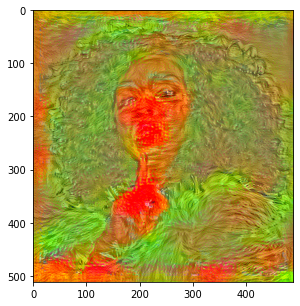

Style Loss: 243790.0625 Content Loss: 1405252.25 TV Loss: 20902.654296875 Total Loss : 1669944.875


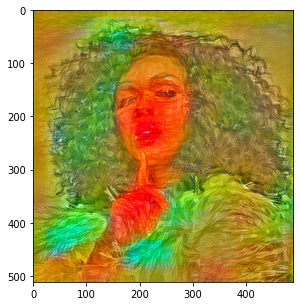

Style Loss: 176539.875 Content Loss: 1301437.5 TV Loss: 22241.73828125 Total Loss : 1500219.125


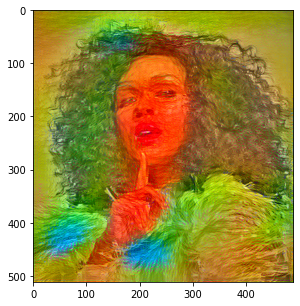

Style Loss: 166301.25 Content Loss: 1262488.125 TV Loss: 23848.158203125 Total Loss : 1452637.5


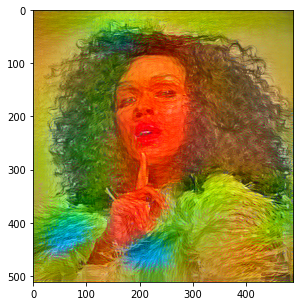

Style Loss: 163603.671875 Content Loss: 1245999.0 TV Loss: 24948.732421875 Total Loss : 1434551.375


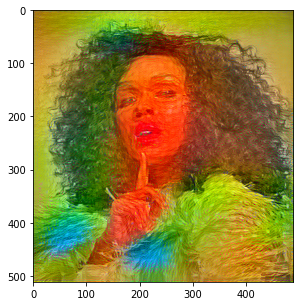

Style Loss: 163636.25 Content Loss: 1245828.875 TV Loss: 24956.36328125 Total Loss : 1434421.5


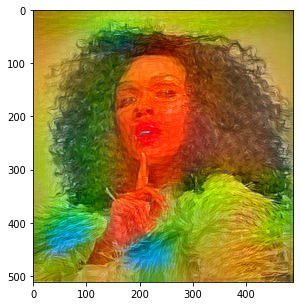

In [ ]:
# Method 2, step 2: The output of the previous step is used as the style, and the face is used as the content
new_style_tensor_m2 = itot(img_con_str_m2).to(device)
# PRESERVE_COLOR = 'False'
# content_layer = 'relu4_1' # use same content layer as step 1 as default, can change to aonther layer
out_content_m2 = stylize(content_tensor,new_style_tensor_m2, g2,'False',content_layer,iteration=NUM_ITER)

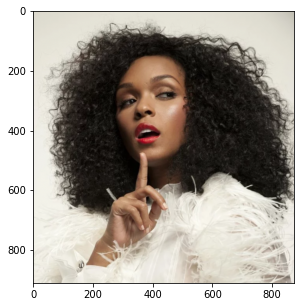

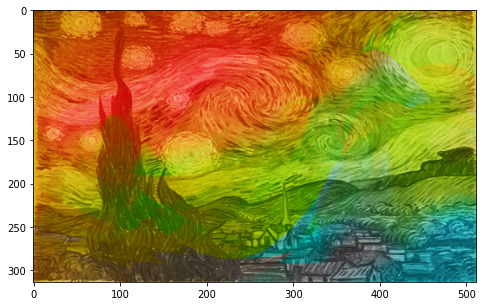

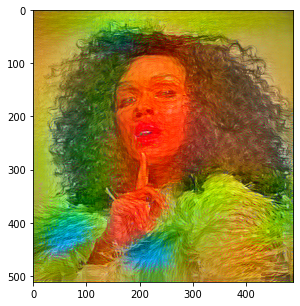

In [ ]:
show(content_img) # Original Content
show(img_con_str_m2) # merge color and style after image processing
show(ttoi(out_content_m2.clone().detach())) # Final Transfer
# saveimg(ttoi(out_content.clone().detach()), NUM_ITER)

# Discussion
1. Overall evaluation of the project
    Compared with the existing style transfer, we successfully added color transfer based on the style transfer. It should be noticed that the color transfer we are trying to achieve is not simple coloring, but hope that artificial intelligence can be like human, abstract/souled coloring, rather than simple overlay. We can see that the shading distribution of the color transfer is irregular. This meets our primary expectations, and it can generate colorful ink abstract paintings or dreamy castles based on different colors and different textures we input.
    - dreamy castles based on different colors and different textures

    ![result 1](https://github.com/yuxin714/9444-Neural-Style-Transfer/blob/main/result2.JPG?raw=true)

    ![result 2](https://github.com/yuxin714/9444-Neural-Style-Transfer/blob/main/result3.JPG?raw=true)
    
    - But we also realize that most of the current style transfer techniques only stop at the transfer of the texture/edge sharpness of the image, which is not enough to replicate the real master works（For Van Gogh's masterpiece Starry Night, style transfer did not really transfer Van Gogh's unique swirling style）. For color transfer, the logic of coloring is only to minimize the loss of information, not to generate aesthetics.

    ![result 3](https://github.com/yuxin714/9444-Neural-Style-Transfer/blob/main/Result1.JPG?raw=true)
2. Comparison of Two different methods of color transfer 

    - Method1 combines texture, color, and content through two style transfers. Method2 first covers the color to the style image, and then performs the style transfer. The color distribution of these two methods is very similar, but the texture effect of the second method is less obvious (more blurry) than the first method. This is because when we overwriting the color in the second method, it destroys the clarity of the texture in style image. 

    ![overlay color to style](https://github.com/yuxin714/9444-Neural-Style-Transfer/blob/main/overlay_color.png?raw=true)

    - From another perspective, the second color transfer scheme is generally successful, and it achieves almost the same final result as the first method on the basis of only one style transfer，this almost double the speed.

3. Comparison of the results of using two VGG networks
    - VGG19 obviously learns more color styles and texture structures than VGG16, so it obtains better transfer effects. The reason is that deeper network layers will help extract details and texture information.

4. Compare with using different network layers
    
    - Deeper network layers may capture more detailed texture information, but lose large-level content information. The ultimate goal of this project is to synthesize good-looking images and improve the artistic creation capabilities of AI, not just to minimize loss. So which layer to choose as the content layer and which layer as the style layer may be important to the final output painting. 

![Comparison of different network layers and networks](https://github.com/yuxin714/9444-Neural-Style-Transfer/blob/main/different_network.png?raw=true)

# Conculsion

After the comparison, our conclusion is: for VGG19 compared to VGG16, it seems to get a thinner brush for painting. Deeper layers of the same network may lead to more abstract paintings. Therefore, we can determine whether the output is realistic or abstract by controlling the content layer and the style layer or color layer to a certain extent. But for art, there is no mathematical definition yet.

![conclusion](https://github.com/yuxin714/9444-Neural-Style-Transfer/blob/main/conclusion.png?raw=true)